# Jores et al 2021 Prototyping 
**Authorship:**
Adam Klie, *08/11/2022*
***
**Description:**
Notebook to perform simple training and evaluation of protype models on the Jores et al (2021) dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/jores21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/jores21"
eu.settings.figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/jores21"
eu.settings.verbosity = logging.ERROR

# Train a model

## Load in the `leaf`, `proto` and `combined` `SeqData`s 

In [3]:
# Load in the preprocessed training data
sdata_leaf = eu.dl.read(os.path.join(eu.settings.dataset_dir, "leaf_processed_train.h5sd"))
sdata_proto = eu.dl.read(os.path.join(eu.settings.dataset_dir, "proto_processed_train.h5sd"))
sdata_combined = eu.dl.concat([sdata_leaf, sdata_proto], keys=["leaf", "proto"])
sdata_leaf, sdata_proto, sdata_combined

(SeqData object with = 65004 seqs
 seqs = (65004,)
 names = (65004,)
 rev_seqs = None
 ohe_seqs = (65004, 4, 170)
 ohe_rev_seqs = (65004, 4, 170)
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 68213 seqs
 seqs = (68213,)
 names = (68213,)
 rev_seqs = None
 ohe_seqs = (68213, 4, 170)
 ohe_rev_seqs = (68213, 4, 170)
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 133217 seqs
 seqs = (133217,)
 names = (133217,)
 rev_seqs = None
 ohe_seqs = (133217, 4, 170)
 ohe_rev_seqs = (133217, 4, 170)
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
 pos_annot: None
 seqsm: None

## Set-up instantiation and initialization of the model

In [4]:
# Grab initialization motifs
core_promoter_elements = eu.dl.motif.MinimalMEME(os.path.join(eu.settings.dataset_dir, 'CPEs.meme'))
tf_groups = eu.dl.motif.MinimalMEME(os.path.join(eu.settings.dataset_dir, 'TF-clusters.meme'))
all_motifs = {**core_promoter_elements.motifs, **tf_groups.motifs}
len(all_motifs)

78

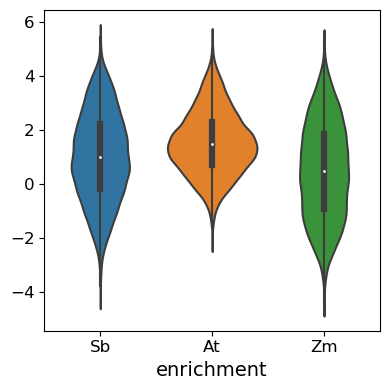

In [9]:
eu.pl.violinplot(
    sdata_leaf,
    keys=["enrichment"],
    groupby="sp",
    figsize=(4, 4),
    save=os.path.join(eu.settings.figure_dir, "leaf_enrichment_violin.pdf"),
)

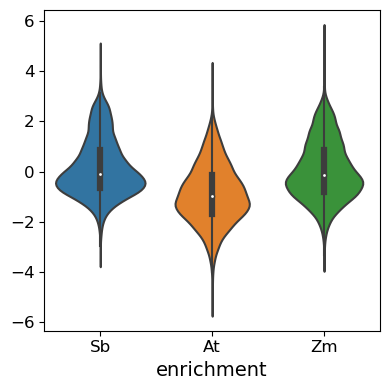

In [10]:
eu.pl.violinplot(
    sdata_proto,
    keys=["enrichment"],
    groupby="sp",
    figsize=(4, 4),
    save=os.path.join(eu.settings.figure_dir, "proto_enrichment_violin.pdf"),
)

In [5]:
from pytorch_lightning import seed_everything

# Function for instantiating a new randomly initialized model
def prep_new_model(
    seed,
    arch,
    config
):
    # Instantiate the model
    model = eu.models.load_config(
        arch=arch,
        model_config=config
    )
    
    seed_everything(seed)
    
    # Initialize the model prior to conv filter initialization
    eu.models.init_weights(model)

    # Initialize the conv filters
    if arch == "Jores21CNN":
        module_name, module_number, kernel_name, kernel_number = "biconv", None, "kernels", 0, 
    elif arch in ["CNN", "Hybrid"]:
        module_name, module_number, kernel_name, kernel_number = "convnet", 0, None, None
    eu.models.init_from_motifs(
        model, 
        all_motifs, 
        module_name=module_name,
        module_number=module_number,
        kernel_name=kernel_name,
        kernel_number=kernel_number
    )

    # Return the model
    return model 

In [8]:
# Instantiate a test model to make sure this is working properly
test_model = prep_new_model(0, "Jores21CNN", os.path.join(eu.settings.config_dir, "Jores21CNN.yaml"))
print(test_model)

Global seed set to 0


## Train a prototype model 

In [17]:
# Initialize the model
leaf_model = prep_new_model(
    arch=model_type, 
    config=os.path.join(eu.settings.config_dir, f"{model_name}.yaml"),
    seed=trial
)

# Train the model
eu.train.fit(
    model=leaf_model, 
    sdata=sdata_leaf, 
    gpus=1, 
    target_keys="enrichment",
    train_key="train_val",
    epochs=1,
    batch_size=128,
    num_workers=0,
    name=model_name,
    seed=trial,
    version=f"leaf_trial_{trial}",
    weights_summary=None,
    verbosity=logging.ERROR
)

# Get predictions on the training data
eu.evaluate.train_val_predictions(
    leaf_model,
    sdata=sdata_leaf, 
    target_keys="enrichment",
    train_key="train_val",
    name=model_name,
    version=f"leaf_trial_{trial}",
    prefix=f"{model_name}_trial_{trial}_"
)

# Save train and validation predictions
sdata_leaf.write_h5sd(os.path.join(eu.settings.output_dir, "leaf_train_predictions.h5sd"))

ssCNN trial 1


Global seed set to 1
Global seed set to 1


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


No transforms given, assuming just need to tensorize.


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True


No transforms given, assuming just need to tensorize.
No transforms given, assuming just need to tensorize.


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

ssHybrid trial 1


Global seed set to 1
Global seed set to 1


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


No transforms given, assuming just need to tensorize.


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True


No transforms given, assuming just need to tensorize.
No transforms given, assuming just need to tensorize.


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Jores21CNN trial 1


Global seed set to 1
Global seed set to 1


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


No transforms given, assuming just need to tensorize.


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize.
No transforms given, assuming just need to tensorize.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

# Evaluate

## Load in the `leaf`, `proto` and `combined` `SeqData`s 

In [ ]:
# Load in the preprocessed test set data
sdata_leaf = eu.dl.read(os.path.join(eu.settings.dataset_dir, "leaf_processed_test.h5sd"))
sdata_proto = eu.dl.read(os.path.join(eu.settings.dataset_dir, "proto_processed_test.h5sd"))
sdata_combined = eu.dl.concat([sdata_leaf, sdata_proto], keys=["leaf", "proto"])
sdata_leaf, sdata_proto, sdata_combined

(SeqData object with = 65004 seqs
 seqs = (65004,)
 names = (65004,)
 rev_seqs = None
 ohe_seqs = (65004, 4, 170)
 ohe_rev_seqs = (65004, 4, 170)
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 68213 seqs
 seqs = (68213,)
 names = (68213,)
 rev_seqs = None
 ohe_seqs = (68213, 4, 170)
 ohe_rev_seqs = (68213, 4, 170)
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 133217 seqs
 seqs = (133217,)
 names = (133217,)
 rev_seqs = None
 ohe_seqs = (133217, 4, 170)
 ohe_rev_seqs = (133217, 4, 170)
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
 pos_annot: None
 seqsm: None

In [ ]:
# Evaluate each leaf model on the test set
model_types = ["CNN", "Hybrid", "Jores21CNN"]
model_names = ["ssCNN", "ssHybrid", "Jores21CNN"]
trials = 5
for model_name, model_type in zip(model_names, model_types):
    for trial in range(1, trials+1):
        print(f"{model_name} trial {trial}")
        model_file = glob.glob(os.path.join(eu.settings.logging_dir, model_name, f"leaf_trial_{trial}", "checkpoints", "*"))[0]
        if model_type == "CNN":
            leaf_model = eu.models.CNN.load_from_checkpoint(model_file)
        elif model_type == "Hybrid":
            leaf_model = eu.models.Hybrid.load_from_checkpoint(model_file)
        elif model_type == "Jores21CNN":
            leaf_model = eu.models.Jores21CNN.load_from_checkpoint(model_file)
        eu.evaluate.predictions(
            leaf_model,
            sdata=sdata_leaf,
            target_keys="enrichment",
            name=model_name,
            version=f"leaf_trial_{trial}",
            file_label="test",
            prefix=f"{model_name}_trial_{trial}_"
        )
        del leaf_model
sdata_leaf.write_h5sd(os.path.join(eu.settings.output_dir, "leaf_test_predictions.h5sd"))

## Performance

In [ ]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = eu.pl.performance_scatter(
    sdata_leaf, 
    targets="enrichment", 
    predictions=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(eu.settings.figure_dir, "leaf_best_model_performance_scatter_by_sp.pdf")
)

## Feature attribution

In [ ]:
# Run three saliency feature attribution methods across all sequences
saliency_methods = ["InputXGradient", "DeepLift", "GradientSHAP"]
for method in saliency_methods:
    eu.interpret.feature_attribution_sdata(
        model=model,
        sdata=sdata,
        method=method
    )

False
No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/55 [00:00<?, ?it/s]

False
No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/55 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  module
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torch/nn/functional.py:651: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note t

False
No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/55 [00:00<?, ?it/s]

Importance values: 0it [00:00, ?it/s]

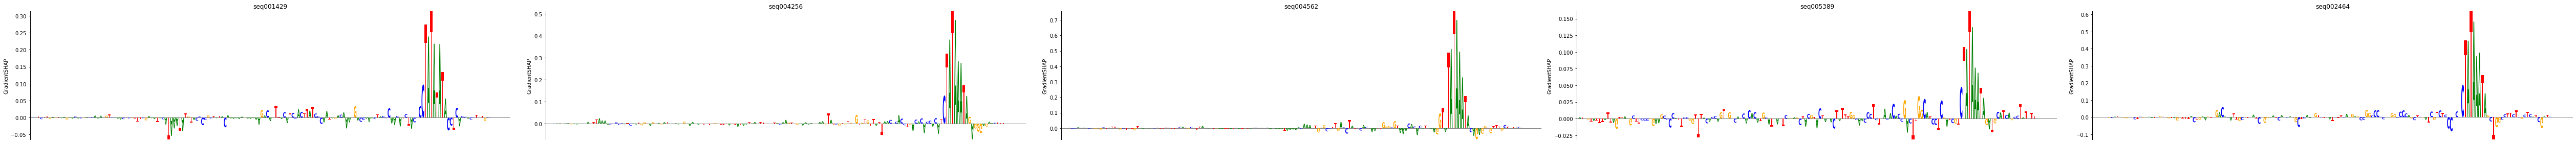

In [ ]:
# Grab the top10 in terms of predictions to plot tracks for
top5 = sdata["ssHybrid_trial_5_enrichment_predictions"].sort_values(ascending=False).iloc[:5].index

eu.pl.lm_multiseq_track(
    sdata,
    seq_ids=top5,
    uns_keys = "GradientSHAP_imps",
    ylabels="GradientSHAP",
    width=70,
    save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_feature_attr.pdf")
)

## Filter viz

In [ ]:
# Generate pfms from filters using method described in Minnoye et al. 2020
eu.interpret.generate_pfms_sdata(
    model=model, 
    sdata=sdata,
    method="Minnoye20"
)

No transforms given, assuming just need to tensorize.


Getting maximial activating seqlets:   0%|          | 0/55 [00:00<?, ?it/s]

['A', 'C', 'G', 'T']


Getting PFMs from filters:   0%|          | 0/256 [00:00<?, ?it/s]

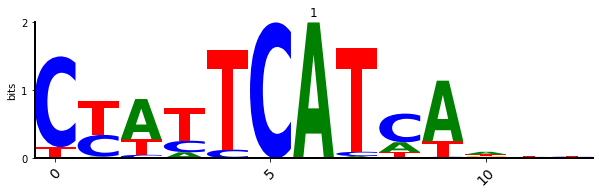

In [ ]:
# Visualize a filter of choice
eu.pl.lm_filter_viz(
    sdata,
    filter_id=1
)

Plotting and saving filters 1-32
Plotting and saving filters 33-64
Plotting and saving filters 65-96
Plotting and saving filters 97-128
Plotting and saving filters 129-160
Plotting and saving filters 161-192
Plotting and saving filters 193-224
Plotting and saving filters 225-256


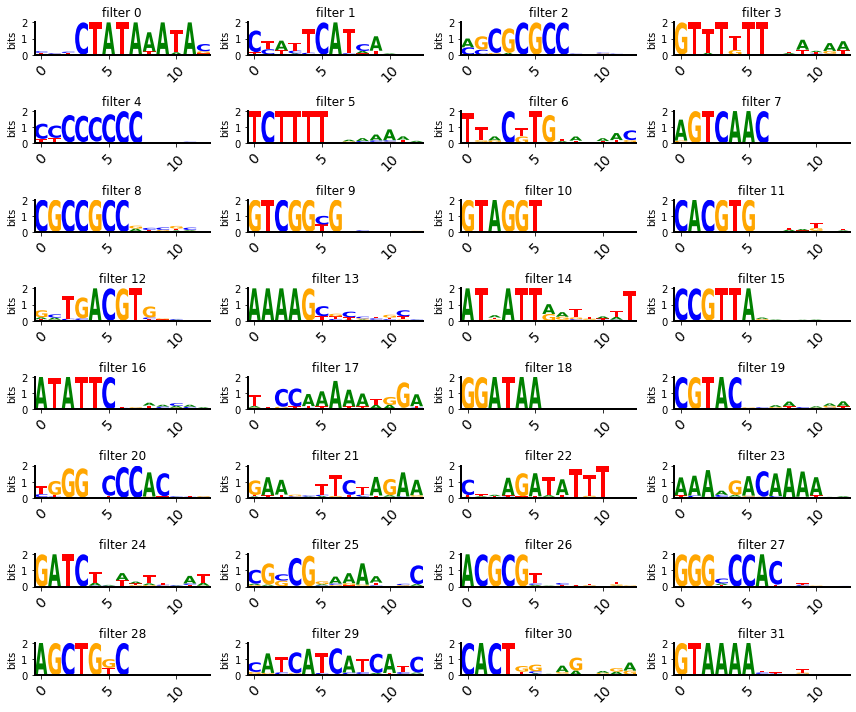

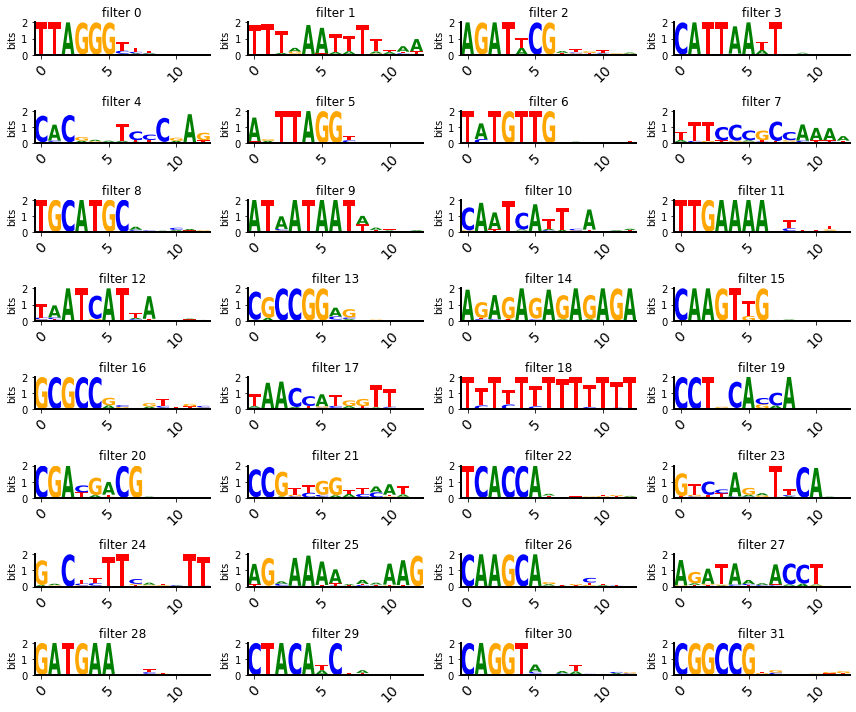

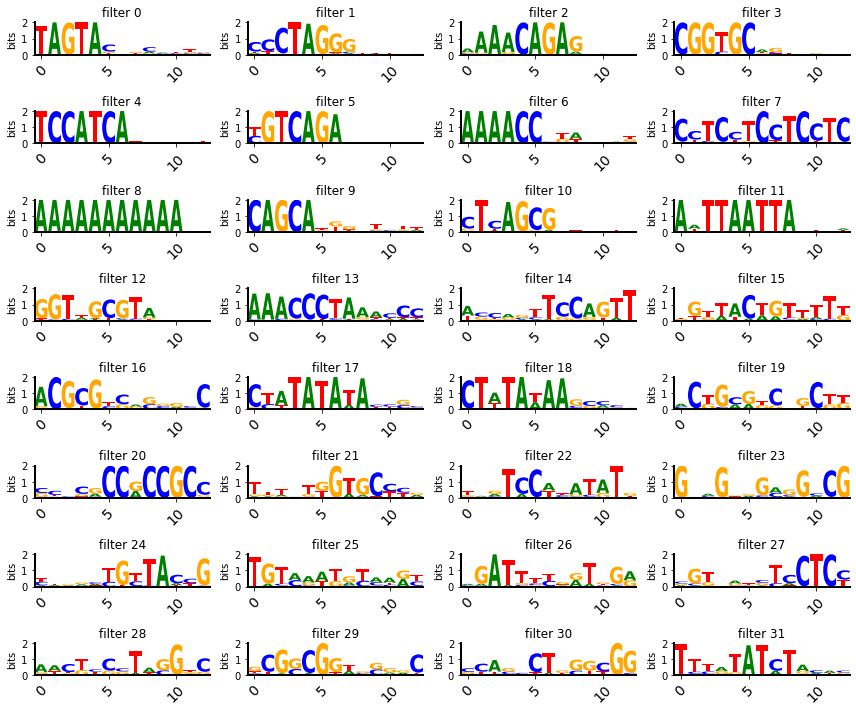

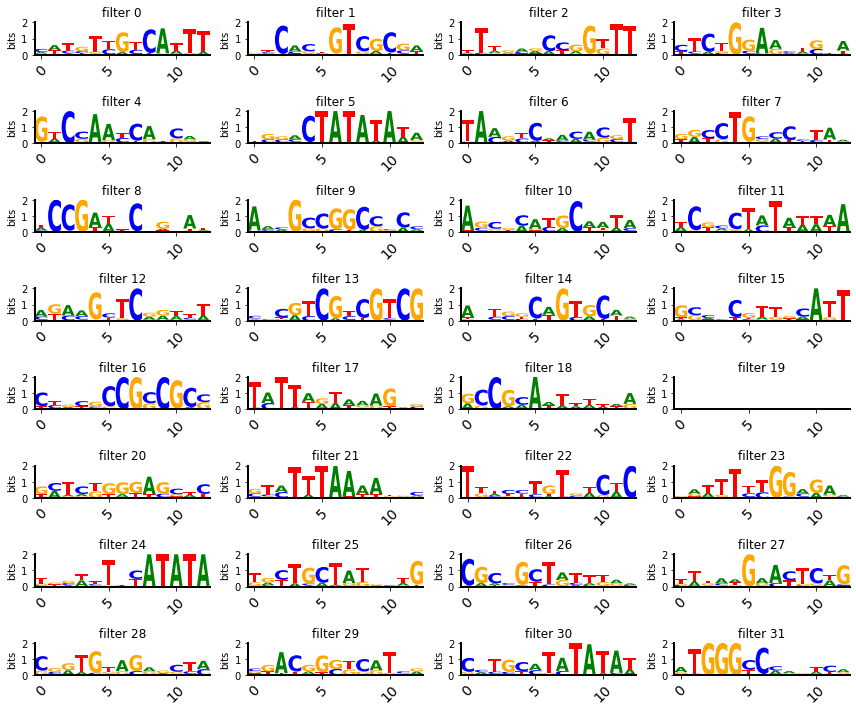

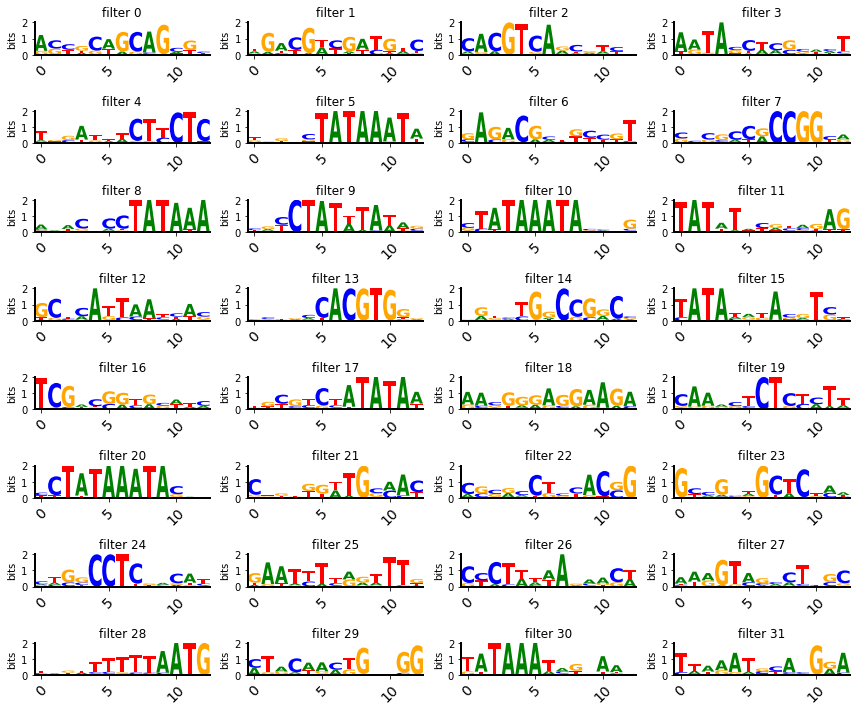

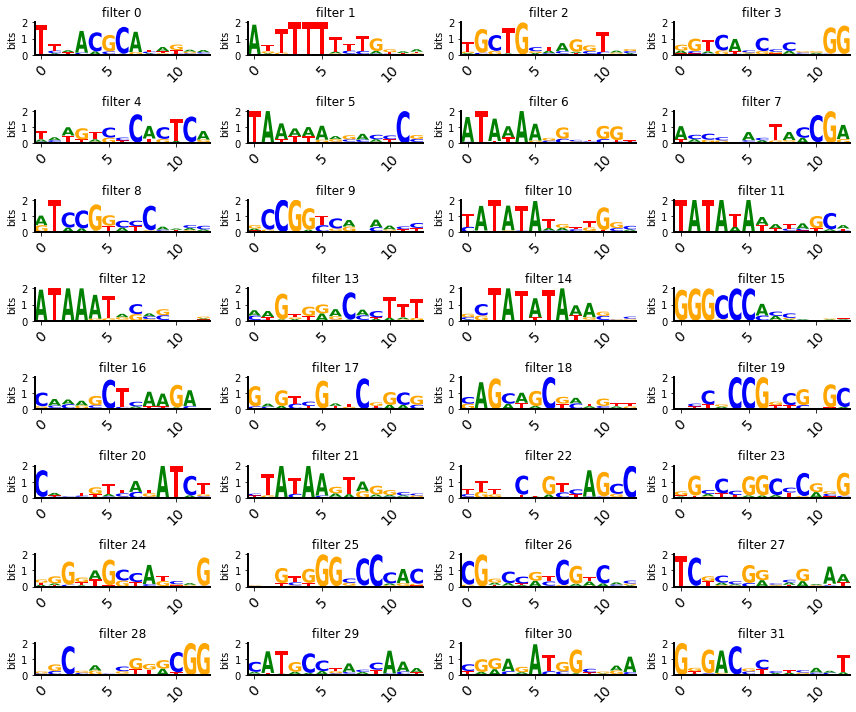

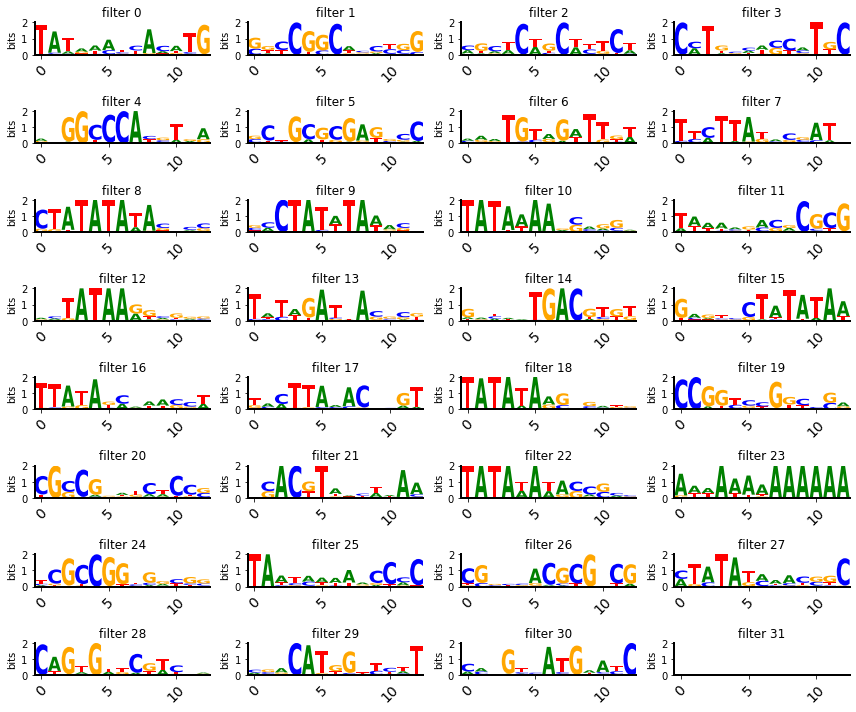

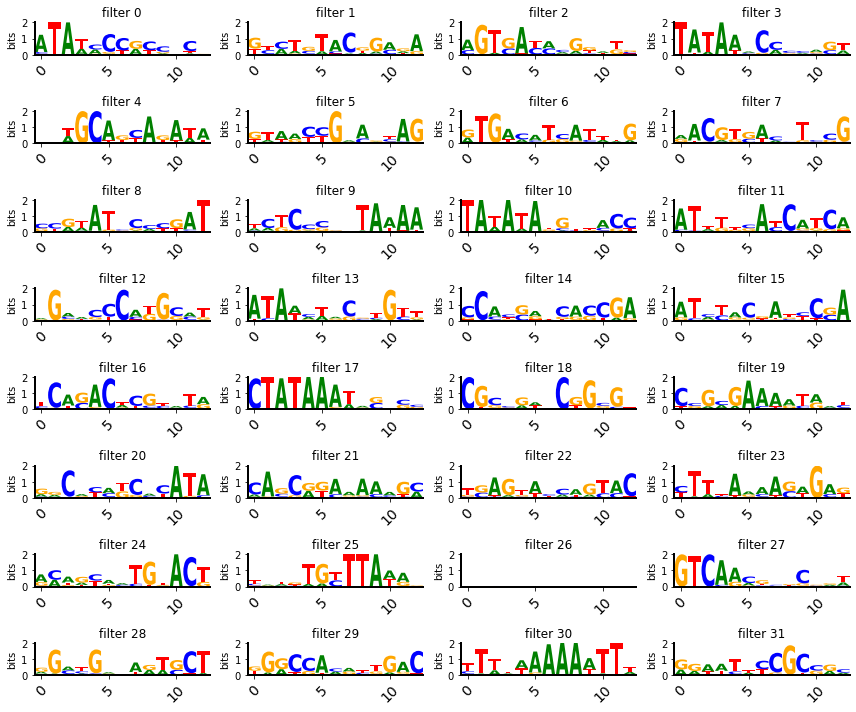

In [ ]:
# Visualize multiple filters at once and save
for i in range(8):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    eu.pl.lm_multifilter_viz(
        sdata,
        filter_ids=list(sdata.uns["pfms"].keys())[start_filter:end_filter],
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(32)],
        save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_filters{start_filter+1}-{end_filter}_viz.pdf")
    )

In [ ]:
# Save all the filter pfms from above as meme format for submission to TomTom
eu.dl.motif.filters_to_meme_sdata(
    sdata,
    filter_ids=list(sdata.uns["pfms"].keys()),
    output_dir=os.path.join(eu.settings.output_dir),
    file_name=f"{name}_best_model_filters.meme"
)

Saved PWM File as : /cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_best_model_filters.meme


## In silico evolution 

In [ ]:
# Load in sequences that were evolved in the published paper
sdata_evolve = eu.dl.read_csv(os.path.join(eu.settings.dataset_dir, "promoters_for_evolution.tsv"), seq_col="sequence", name_col="name")
eu.pp.ohe_seqs_sdata(sdata_evolve)
sdata_evolve

One-hot encoding sequences:   0%|          | 0/310 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 310 ohe_seqs added


SeqData object with = 310 seqs
seqs = (310,)
names = (310,)
rev_seqs = None
ohe_seqs = (310, 4, 170)
ohe_rev_seqs = None
seqs_annot: 'target'
pos_annot: None
seqsm: None
uns: None

In [ ]:
# Evolve them using the best model across 10 rounds
eu.interpret.evolve_seqs_sdata(
    model,
    sdata_evolve,
    rounds=10
)

Evolving seqs:   0%|          | 0/3 [00:00<?, ?it/s]

SeqData object modified:
    seqs_annot:
        + evolved_2_score, evolved_4_score, evolved_3_score, evolved_9_score, evolved_7_score, evolved_1_score, evolved_8_score, evolved_10_score, evolved_5_score, evolved_6_score


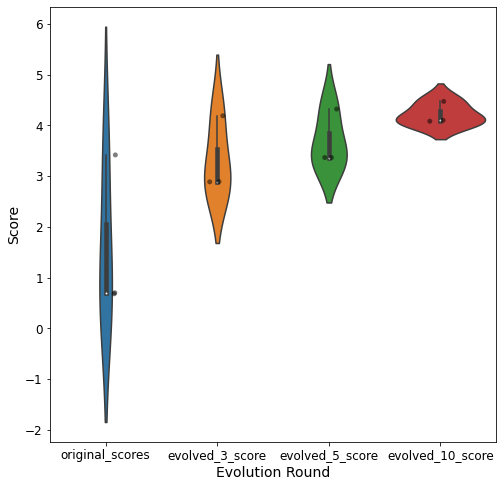

In [ ]:
eu.pl.violinplot(
    sdata_evolve,
    groupby=["original_score", "evolved_3_score", "evolved_5_score", "evolved_10_score"],
    xlabel="Evolution Round",
    ylabel="Score",
    #save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_evolution_summary.pdf")
)

## In silico feature implant

In [ ]:
sdata_evolve = eu.dl.read_csv(os.path.join(eu.settings.dataset_dir, "promoters_for_evolution.tsv"), seq_col="sequence", name_col="name")
eu.pp.ohe_seqs_sdata(sdata_evolve)
sdata_evolve

One-hot encoding sequences:   0%|          | 0/310 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 310 ohe_seqs added


SeqData object with = 310 seqs
seqs = (310,)
names = (310,)
rev_seqs = None
ohe_seqs = (310, 4, 170)
ohe_rev_seqs = None
seqs_annot: 'target'
pos_annot: None
seqsm: None
uns: None

In [ ]:
# Prep feature from meme file
meme = eu.dl.motif.MinimalMEME(path=os.path.join(eu.settings.dataset_dir, "CPEs.meme"))
motif = meme.motifs["TATA"]
name = motif.name
pfm = motif.pfm
uniform_pfm = np.zeros(pfm.shape) + 0.25
rand_pfm = np.random.normal(loc=0, scale=1, size=pfm.shape)
consensus = motif.consensus
name, pfm, consensus

('TATA',
 array([[0.1275, 0.3765, 0.1195, 0.3765],
        [0.1575, 0.3985, 0.199 , 0.2455],
        [0.249 , 0.303 , 0.197 , 0.251 ],
        [0.1235, 0.655 , 0.0755, 0.1455],
        [0.01  , 0.002 , 0.002 , 0.986 ],
        [0.968 , 0.    , 0.    , 0.032 ],
        [0.002 , 0.014 , 0.006 , 0.978 ],
        [0.992 , 0.    , 0.002 , 0.006 ],
        [0.653 , 0.012 , 0.002 , 0.333 ],
        [0.974 , 0.    , 0.008 , 0.018 ],
        [0.341 , 0.028 , 0.036 , 0.5955],
        [0.6955, 0.0815, 0.1195, 0.1035],
        [0.1255, 0.432 , 0.3165, 0.1255],
        [0.291 , 0.418 , 0.175 , 0.1155],
        [0.263 , 0.3445, 0.1755, 0.2175],
        [0.307 , 0.3085, 0.2365, 0.1475]]),
 'CCCCTATAAATACCCC')

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

(310, 167)

In [ ]:
# Slide a random pfm across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=rand_pfm,
    seqsm_key=f"slide_random",
    encoding="onehot", 
    onehot=True
)
sdata_evolve.seqsm[f"slide_random"].shape

# Slide a uniform pfm across the sequences 
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=uniform_pfm,
    seqsm_key=f"slide_uniform",
    encoding="onehot", 
    onehot=True
)

# Slide the TATA motif across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=pfm, 
    seqsm_key=f"slide_{name}",
    encoding="onehot", 
    onehot=True
)

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/310 [00:00<?, ?it/s]

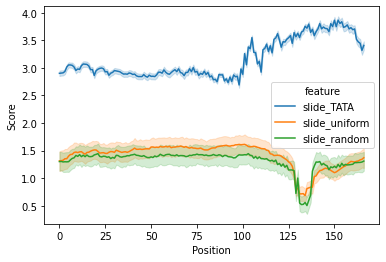

In [ ]:
eu.pl.feature_implant_plot(
    sdata_evolve,
    seqsm_keys=[f"slide_{name}", f"slide_uniform", f"slide_random"],
    save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_feature_implant.pdf")
)

---

# Scratch